In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import geopy.distance
import geopy.point

In [14]:
df_skiers = pd.read_csv("../data/filtered/Dati_filtrati_all.csv")
df_skiers = df_skiers[df_skiers["DNF"] == False]



In [15]:
def calculate_distance(df):

    distance = 0
    
    for long1, lat1, alt1, long2, lat2, alt2 in zip(df["GNSS_Longitude"][:-1], df["GNSS_Latitude"][:-1], df["GNSS_Altitude"][:-1],df["GNSS_Longitude"][1:], df["GNSS_Latitude"][1:],df["GNSS_Altitude"][1:]):

        distance2d = geopy.distance.geodesic((long1, lat1), (long2, lat2)).m
        distance += np.sqrt(distance2d**2 + (alt1 - alt2)**2)

    return distance

Number of gates is 28
gps martin
gps meggye
gps cate
gps ilaria
gps aydan
gps giorgio
gps ela
gps bea


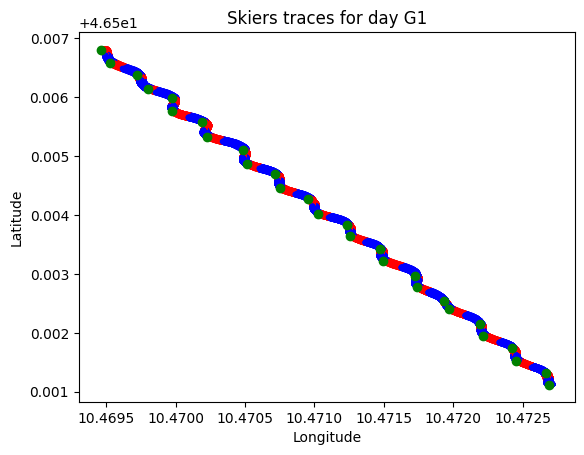

Number of gates is 21
gps zavattarelli 
gps vala manka
gps gal
gps bea_2
gps jelenček
gps cate_3
gps nik


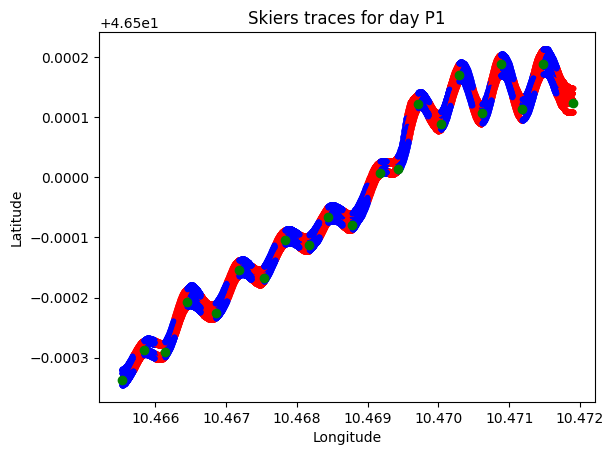

Number of gates is 21
gps manca
gps zavattarelli _2
gps gal_2
gps cate_4
gps francesco
gps chiara
gps bea_4
gps sofia


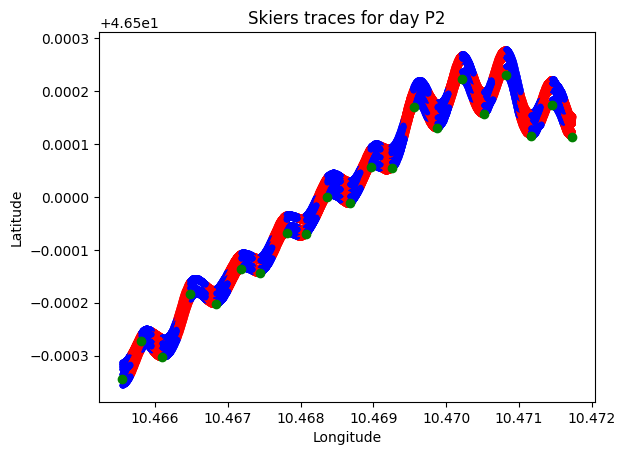

In [16]:
for day in ["G1", "P1", "P2"]:
    edge_changes_df = pd.read_csv(f"../data/{day}/edge_change.csv")
    gate_coordinates_df = pd.read_csv(f"../data/{day}/gate_coordinates.csv")

    number_of_gates = np.max(gate_coordinates_df["num"])

    print("Number of gates is", number_of_gates)

    df_skiers_day = df_skiers[df_skiers["Day"] == day]


    for athlete, skier_file, startTime, duration in zip(df_skiers_day["Atleta"], df_skiers_day["File_gps"], df_skiers_day["StartTime"], df_skiers_day["Time"]):
        df_skier = pd.read_csv(skier_file)
        df_skier_started = df_skier[df_skier["Timestamp"] >= startTime]
        df_skier_run = df_skier_started[df_skier_started["Timestamp"] <= startTime + duration]
        df_skier_run = df_skier_run.sort_values('Timestamp', ascending=False)
        df_skier_run["AccelerationMagnitude"] = (df_skier_run["Accelerometer_X"] ** 2 + df_skier_run["Accelerometer_Y"] ** 2 + df_skier_run["Accelerometer_Z"] ** 2) ** 0.5

        df_skier_run.reset_index(inplace=True)

        print(athlete)


        first_part_curve = []
        second_part_curve = []

        distances_first_part, distances_second_part = [], []
        velocity_first_part, velocity_second_part = [], []
        acc_first_part, acc_second_part = [], []
        prev_gate = None


        for gate_index in range(1, number_of_gates):
            gate_loc = gate_coordinates_df.to_numpy()[gate_index - 1][1:]
            edge_change_loc = edge_changes_df.to_numpy()[gate_index - 1][1:]
            next_gate_loc = gate_coordinates_df.to_numpy()[gate_index][1:]

            if prev_gate == None:
                df_skier_run_copy = df_skier_run.copy()

                df_skier_run_copy["gate_long"], df_skier_run_copy["gate_lat"] = gate_loc[0], gate_loc[1]

                df_skier_run_copy["Dist_gate"] = (df_skier_run_copy["GNSS_Longitude"] - df_skier_run_copy["gate_long"]) ** 2 + (df_skier_run_copy["GNSS_Latitude"] - df_skier_run_copy["gate_lat"]) ** 2


                index_nearest_pos_to_gate = df_skier_run_copy[df_skier_run_copy["Dist_gate"] == np.min(df_skier_run_copy["Dist_gate"])].index[0]

            else:
                index_nearest_pos_to_gate = prev_gate


            df_skier_run_copy = df_skier_run.copy()

            df_skier_run_copy["edge_change_long"], df_skier_run_copy["edge_change_lat"] = edge_change_loc[0], edge_change_loc[1]

            df_skier_run_copy["Dist_edge_change"] = (df_skier_run_copy["GNSS_Longitude"] - df_skier_run_copy["edge_change_long"]) ** 2 + (df_skier_run_copy["GNSS_Latitude"] - df_skier_run_copy["edge_change_lat"]) ** 2

            index_nearest_pos_to_edge_change_lat = df_skier_run_copy[df_skier_run_copy["Dist_edge_change"] == np.min(df_skier_run_copy["Dist_edge_change"])].index[0]

            
            df_skier_run_copy = df_skier_run.copy()

            df_skier_run_copy["gate_long"], df_skier_run_copy["gate_lat"] = next_gate_loc[0], next_gate_loc[1]

            df_skier_run_copy["Dist_gate"] = (df_skier_run_copy["GNSS_Longitude"] - df_skier_run_copy["gate_long"]) ** 2 + (df_skier_run_copy["GNSS_Latitude"] - df_skier_run_copy["gate_lat"]) ** 2

            index_nearest_pos_to_next_gate = df_skier_run_copy[df_skier_run_copy["Dist_gate"] == np.min(df_skier_run_copy["Dist_gate"])].index[0]


            first_part_curve_indexes_this_gate = list(range(np.min([index_nearest_pos_to_gate, index_nearest_pos_to_edge_change_lat]), np.max([index_nearest_pos_to_gate, index_nearest_pos_to_edge_change_lat])))
            first_part_curve += first_part_curve_indexes_this_gate
            
            second_part_curve_indexes_this_gate = list(range(np.min([index_nearest_pos_to_next_gate, index_nearest_pos_to_edge_change_lat]), np.max([index_nearest_pos_to_next_gate, index_nearest_pos_to_edge_change_lat])))
            second_part_curve += second_part_curve_indexes_this_gate

            first_part_curve_df = df_skier_run.loc[first_part_curve_indexes_this_gate]
            second_part_curve_df = df_skier_run.loc[second_part_curve_indexes_this_gate]

            distances_first_part.append(calculate_distance(first_part_curve_df))
            distances_second_part.append(calculate_distance(second_part_curve_df))

            velocity_first_part.append(np.mean(first_part_curve_df["GNSS_SpeedOverGround"]))
            velocity_second_part.append(np.mean(second_part_curve_df["GNSS_SpeedOverGround"]))

            acc_first_part.append(np.mean(first_part_curve_df["AccelerationMagnitude"]))
            acc_second_part.append(np.mean(second_part_curve_df["AccelerationMagnitude"]))


            prev_gate = index_nearest_pos_to_next_gate


        df_athlete_curves = pd.DataFrame(columns = ["Curve_after_gate", "Distance_first_part", "Distance_second_part", "Vel_first_part", "Vel_second_part", "Acc_first_part", "Acc_second_part"])
        df_athlete_curves["Curve_after_gate"] = list(range(1, number_of_gates))
        df_athlete_curves["Distance_first_part"] = distances_first_part
        df_athlete_curves["Distance_second_part"] = distances_second_part
        df_athlete_curves["Vel_first_part"] = velocity_first_part
        df_athlete_curves["Vel_second_part"] = velocity_second_part
        df_athlete_curves["Acc_first_part"] = acc_first_part
        df_athlete_curves["Acc_second_part"] = acc_second_part

        df_athlete_curves.to_csv(f"../data/filtered/curve_filtering/{athlete}_{day}_curves.csv", index=False)

        first_part_curve_df = df_skier_run.loc[first_part_curve]
        second_part_curve_df = df_skier_run.loc[second_part_curve]


        plt.scatter(first_part_curve_df["GNSS_Longitude"], first_part_curve_df["GNSS_Latitude"], label = athlete, color = "red", marker=".")
        plt.scatter(second_part_curve_df["GNSS_Longitude"], second_part_curve_df["GNSS_Latitude"], label = athlete, color = "blue", marker=".")
        plt.scatter(gate_coordinates_df["longitude"], gate_coordinates_df["latitude"], color = "green", marker=".")



    plt.scatter(gate_coordinates_df["longitude"], gate_coordinates_df["latitude"], color = "green")

    plt.title(f"Skiers traces for day {day}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    #plt.legend()
    plt.savefig(f"../figures/skiers_traces_day_{day}")
    plt.show()